## Setup

In [1]:
%%capture
%pip install -U bitsandbytes loralib
%pip install -U transformers
%pip install -U peft
%pip install -U accelerate
%pip install -U trl
%pip install datasets==2.16.0


In [7]:
import os 
PROJECT_DIR_PATH = ''
OUTPUT_PATH = os.path.join(PROJECT_DIR_PATH, 'models')

BASELINE_MODEL_NAME = 'OpenPipe/mistral-ft-optimized-1227'
PROJECT_NAME = 'OpenPipe_mistral-ft-optimized-1227'
HUGGING_FACE_REPO_NAME = f'achdaisy/{PROJECT_NAME}'
HUGGING_FACE_MERGED_REPO_NAME = f'{HUGGING_FACE_REPO_NAME}_merged'

In [9]:
#For the access token of hugging face and weights and biases
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_hf = user_secrets.get_secret("hf")
secret_wandb = user_secrets.get_secret("wnb")

In [10]:
#logging in to hf
!huggingface-cli login --token $secret_hf

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [11]:
#logging in to weights and biases
import wandb
wandb.login(key = secret_wandb)
run = wandb.init(
    project='Fine tuning openpipe mistral 7B', 
    job_type="training", 
    anonymous="allow"
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: oduordaizy. Use `wandb login --relogin` to force relogin


## Dataset

In [ ]:
import pandas as pd
train = pd.read_csv("/kaggle/input/books-finetuning-dataset/books_data.csv",encoding='latin-1')
train = train[[ "Key Words/Categories","Book Title"]]
train = train.values.tolist()

In [12]:
# Get tokenizer.
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained(BASELINE_MODEL_NAME,
                                                       padding_side='left',
                                                       add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Preprocessing

In [14]:
def dialogue_to_chat(dialogue):
    out = [{'role': 'system', 'content': 'You are a book retriever.'}]
    for idx, message in enumerate(dialogue):
        role = 'user' if idx%2==0 else 'assistant'
        out.append({'role': role, 'content': message})
    return out

def chat_to_input(chat):
    return tokenizer.apply_chat_template(chat, tokenize=False)

def process_example(example):
    out = dialogue_to_chat(example)                
    out = chat_to_input(out)                    
    return out


In [16]:
data = []
for i in range(len(train)):
    data.append(process_example(train[i]))
    


No chat template is defined for this tokenizer - using the default template for the LlamaTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



TypeError: can only concatenate str (not "float") to str

In [17]:
# Shuffle dataset.
from random import shuffle
shuffle(data)

# Tokenize data.
tokenized_data = list(map(tokenizer, data))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


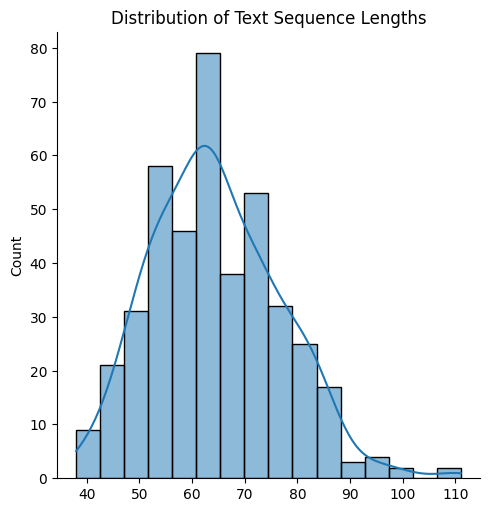

In [18]:
# Plot sequence Lengths.
import seaborn as sns

input_lengths = [len(x['input_ids']) for x in tokenized_data]
sns.displot(input_lengths, kde=True).set(title='Distribution of Text Sequence Lengths')

Sequence lengths after processing and tokenization are mostly smaller than 400 tokens. Let’s maintain a maximum length size of 512 tokens during the finetuning phase.

In [22]:
#splitting the data into 90% training and 10% validation
split_idx = int(.90 * len(data))
train_data, val_data = tokenized_data[:split_idx], tokenized_data[split_idx:]
# train_data = tokenized_data

## Model

In [24]:
import transformers, torch

In [25]:
#Initializing the large language model from the transformers library
#loading in 4 bit quantization to reduce the preciison of the model weights

model = transformers.AutoModelForCausalLM.from_pretrained(BASELINE_MODEL_NAME,
                                                          load_in_4bit=True,    
                                                          device_map='auto')

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
# Set PEFT adapter config (16:32).
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

#LoraConfig configures the LORA training parameters
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],     # Apply to "q_proj", "v_proj" layers of attention as suggested by paper
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM")

# Stabilize output layer and layernorms & prepare for 4bit training(reduced precision).
model = prepare_model_for_kbit_training(model)

# Set PEFT adapter on model.
model = get_peft_model(model, config)

## Training

In [17]:
# Set Hyperparameters.
MAXLEN=512
BATCH_SIZE=4
GRAD_ACC=4  #number of gradient accumulation steps
WARMUP=1
STEPS=700  #number of training steps
OPTIMIZER='paged_adamw_8bit'                   # Use paged optimizer to save memory
LR=1.0e-5  #learning rate                      # Use value slightly smaller than pretraining lr value & close to LoRA standard

# Setup Callbacks.
# early_stop = transformers.EarlyStoppingCallback(10, 1.15)

# Set training config.
training_config = transformers.TrainingArguments(
                       per_device_train_batch_size=BATCH_SIZE,
                       gradient_accumulation_steps=GRAD_ACC,
                       warmup_steps=WARMUP,
                       max_steps=STEPS,
                       optim=OPTIMIZER,
                       learning_rate=LR,
                       fp16=True,                            # Consider using bf16 if compatible with your GPU
                       logging_steps=1,
                       output_dir=OUTPUT_PATH,
                       report_to='wandb',
                       load_best_model_at_end=True,
                       evaluation_strategy='steps',
                       metric_for_best_model='eval_loss',
                       greater_is_better=False,
                       eval_steps=100,
                       save_steps=100,
                       save_total_limit=2)

# Setup collator.
data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)


2024-03-31 13:04:57.089727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 13:04:57.089834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 13:04:57.386302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
# Setup trainer.
trainer = transformers.Trainer(model=model,
                               train_dataset=train_data,
                               eval_dataset=val_data,
                               data_collator=data_collator,
                               args=training_config)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [19]:
# Setup trainer.
model.config.use_cache = False  # silence warnings related to cache usage in the model. 
trainer.train()    #starts the training process

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:391: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn('Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True o

Step,Training Loss,Validation Loss
100,1.526000,1.471282
200,1.222100,1.183132
300,1.080400,1.075262
400,0.876700,1.006785
500,0.832900,0.986273
600,0.831300,0.986210
700,0.792600,0.988819
800,0.802000,1.001412
900,0.723600,1.007255
1000,0.765000,1.011655


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=1.0368962189555169, metrics={'train_runtime': 7733.5681, 'train_samples_per_second': 2.069, 'train_steps_per_second': 0.129, 'total_flos': 5.292258947629056e+16, 'train_loss': 1.0368962189555169, 'epoch': 43.96})

In [20]:
# Push to HF Hub.
model.push_to_hub(HUGGING_FACE_REPO_NAME)     

adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/achdaisy/OpenPipe_mistral-ft-optimized-1227/commit/540d63d5cf53328f333ce6066a87beb5835a0b41', commit_message='Upload model', commit_description='', oid='540d63d5cf53328f333ce6066a87beb5835a0b41', pr_url=None, pr_revision=None, pr_num=None)

In [21]:
tokenizer.push_to_hub(HUGGING_FACE_REPO_NAME)   

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/achdaisy/OpenPipe_mistral-ft-optimized-1227/commit/296a0676a7fdb3134b4bfaa03820f0e625d102ea', commit_message='Upload tokenizer', commit_description='', oid='296a0676a7fdb3134b4bfaa03820f0e625d102ea', pr_url=None, pr_revision=None, pr_num=None)

## Merge Adapters to dequantized model or base



In [13]:
# combining pre-trained adapter modules with a 
# model that has been dequantized or a base model. 

import torch
# Get peft config.
from peft import PeftConfig
config = PeftConfig.from_pretrained(HUGGING_FACE_REPO_NAME)

# Get base model
model = transformers.AutoModelForCausalLM.from_pretrained(BASELINE_MODEL_NAME,
                                                          torch_dtype=torch.float16,      # GPTQ quantization requires fp16
                                                          return_dict=True)

# Load the Lora model.
from peft import PeftModel
model = PeftModel.from_pretrained(model, HUGGING_FACE_REPO_NAME)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

In [14]:
# Merge model and Lora adapter.
merged_model = model.merge_and_unload()

# merges the parameters of the adapter with the parameters of the base model 
#and then unloads the adapter,effectively integrating its functionality into the base model.

In [15]:
# Push to HF Hub.
merged_model.push_to_hub(HUGGING_FACE_MERGED_REPO_NAME)


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/achdaisy/OpenPipe_mistral-ft-optimized-1227_merged/commit/0470582a0c200ed4d2c8dcedce3d5082e74404f3', commit_message='Upload MistralForCausalLM', commit_description='', oid='0470582a0c200ed4d2c8dcedce3d5082e74404f3', pr_url=None, pr_revision=None, pr_num=None)

In [16]:
tokenizer.push_to_hub(HUGGING_FACE_MERGED_REPO_NAME)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/achdaisy/OpenPipe_mistral-ft-optimized-1227_merged/commit/36e0f87ba0b4ce4068d1472a552e9f53c987fce5', commit_message='Upload tokenizer', commit_description='', oid='36e0f87ba0b4ce4068d1472a552e9f53c987fce5', pr_url=None, pr_revision=None, pr_num=None)

In [24]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def respond(query):
    model_input = tokenizer(query, return_tensors="pt").to("cuda")
    output = model.generate(input_ids=model_input["input_ids"].to(device),
                           attention_mask=model_input["attention_mask"], 
                           max_new_tokens=125, repetition_penalty=1.15)
    result = tokenizer.decode(output[0], skip_special_tokens=True).replace(eval_prompt, "")
    return result

In [28]:
device

device(type='cuda')

In [ ]:
train[0]

In [27]:
answer = respond(train[0][0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1460: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cuda, whereas the model is on cpu. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cpu') before running `.generate()`.
  warnings.warn(


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)